**Informe N°1 Astronomía Experimental: códigos** \
Profesores: Leonardo Bronfman A. y Patricio Rojo \
Auxiliar: Lukas Philippi Y. \
Estudiante: Antonella Zavala Cerda 


In [16]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd


**Hot-Cold test**


In [17]:
# Se abre tabla excel con resultados de Hot-Cold test entregados: 
print("Abrimos excel Hot-Cold test")
# se ordenan datos de tabla
df_1 = pd.read_excel("HCT_AE2020A.xlsx", usecols="A:F", skiprows=[5])
df_1.rename(columns={"Unnamed: 0": "Variable 1",
                     "Unnamed: 1": "Valor 1",
                     "Unnamed: 2": "Unidad 1",
                     "Unnamed: 3": "Variable 2",
                     "Unnamed: 4": "Valor 2",
                     "Unnamed: 5": "Valor 2"},
            inplace = True)                 
        
df_1 = df_1.drop(index = [0, 1])
print(df_1) # print df_1 
#print(df_1.columns)

Abrimos excel Hot-Cold test
  Variable 1  Valor 1 Unidad 1 Variable 2 Valor 2 Valor 2
2      P_hot   -44.50      dBm   T_hot =    300.0       K
3     P_cold   -47.94      dBm   T_cold =    77.0       K


Se procede a calcular $T_{rec}$, utilizando las ecuaciones dispuestas en el apunte 1.

$(1)$ $$ Y = \frac{T_{rec} + T_{hot}}{T_{rec} + T_{cold}}$$
Se obtiene $(2)$ $$T{rec} = \frac{T_{hot} - Y \cdot T_{cold}}{Y - 1}$$

In [18]:
# Se extraen datos de las columnas del excel:
P = df_1["Valor 1"].values

# Se transforma de dBm a mW:
Ph = 10 ** (P[0]/10) 
Pc = 10 ** (P[1]/10)

# Se calcula y1:
y1 = Ph/Pc

# Se sustituye en la fórmula de T_rec: 
# Se ocupan los datos de T_hot y T_cold dados en la tabla
T_rec = (300 - (y1 * 77))/ (y1 - 1)
print(f"T_rec: {T_rec}")

T_rec: 107.60192572483207


**Antenna Tipping**

objetivo: fiteo de $tau_0$ (o $tau_{\omega}$)

In [19]:
# Se abre tabla excel con resultados de Antenna Tipping entregados 
print("Abrimos excel Antena Tipping")
df_2 = pd.read_excel("antdip_AE2021A.xlsx", usecols="A:H", skiprows=[11])
print(df_2)

Abrimos excel Antena Tipping
   Punto     EL      z  -SEC ('z')   Psky    Psky.1            dP     ln(dP)
0      1  23.50  66.50   -2.507843 -45.56  0.000028  7.358911e-06 -11.819599
1      2  16.60  73.40   -3.500318 -45.22  0.000030  5.095281e-06 -12.187196
2      3  12.84  77.16   -4.499858 -45.01  0.000032  3.605998e-06 -12.532912
3      4  10.48  79.52   -5.497759 -44.88  0.000033  2.647314e-06 -12.841965
4      5   8.85  81.15   -6.499915 -44.80  0.000033  2.042932e-06 -13.101125
5      6   7.66  82.34   -7.502195 -44.73  0.000034  1.504887e-06 -13.406793
6      7   6.76  83.24   -8.495403 -44.71  0.000034  1.349560e-06 -13.515732
7      8   6.04  83.96   -9.503649 -44.67  0.000034  1.036753e-06 -13.779417
8      9   5.47  84.53  -10.490477 -44.64  0.000034  8.002493e-07 -14.038343
9     10   4.99  85.01  -11.496648 -44.63  0.000034  7.210510e-07 -14.142556


$\rightarrow$ Consideramos $dP = \Delta  (el) = W_{amb} - W_{sky}(el)$ y aplicamos logaritmo a la ecuación del apunte: 

$(1)$ $$ \Delta W(el) = W_{amb} - W_{sky} = G_{rec} \cdot k  \cdot \Delta \nu \cdot  T_{amb}  \cdot \exp{\frac{-\tau_0}{sen(el)}}$$

Aplicando logaritmo natural

$(2)$ $$ ln(\Delta W(el)) = ln (G_{rec} \cdot k \cdot \Delta \nu \cdot T_{amb}) - \frac{\tau_0}{sen(el)}$$ 

A (intercepto) = -11.3353 ± 0.0883
tau0 = 0.2574 ± 0.0117


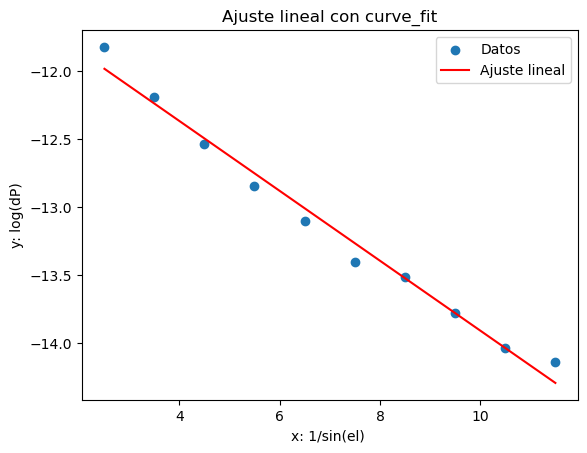

In [20]:
# Se definen las variables:
z = df_2["z"].values # ángulo cenital en grados
el = df_2["EL"].values # elevación en grados
dP = df_2["dP"].values # ΔP = Wamb - Wsky

# Como no se exportó en la tabla el valor de tau_0, se define a continuación:
tau_0 = 0.257350079

# Se define X: masa de aire (cuánta atmósfera se atraviesa según el ángulo de elevación el)
X = 1 / np.sin(np.radians(el)) 

# Se define Y: logaritmo natural de ΔP
Y = np.log(dP)

# S define modelo lineal:
def lineal(X, A, tau_0):
    return A - tau_0 * X

# Se realiza el ajuste:
popt, pcov = curve_fit(lineal, X, Y)

A_fit, tau_0_fit = popt
A_err, tau_0_err = np.sqrt(np.diag(pcov))

print(f"A (intercepto) = {A_fit:.4f} ± {A_err:.4f}")
print(f"tau0 = {tau_0_fit:.4f} ± {tau_0_err:.4f}")

plt.scatter(X, Y, label='Datos')
plt.plot(X, lineal(X, *popt), label='Ajuste lineal', color='red')
plt.xlabel('x: 1/sin(el) ')
plt.ylabel('y: log(dP)')
plt.title('Ajuste lineal con curve_fit')
plt.legend()
plt.show()


**Espectros**

In [21]:
import zipfile
# para identificar cantidad de filas
ruta_zip = "datos_espectros_2025 (1).zip"

with zipfile.ZipFile(ruta_zip, "r") as z:
    with z.open("sdf_125_125") as f:
        # Se lee todo el archivo
        lineas = f.read().decode("utf-8", errors = "ignore").splitlines()


In [22]:
dataframes = []

with zipfile.ZipFile(ruta_zip, "r") as z:
    for nombre in z.namelist():
        if nombre.startswith("sdf_"):
            with z.open(nombre) as f:
                #Se saltan las primeras 108 filas
                df = pd.read_csv(f, skiprows = 108, sep = r"\s+", # separación por espacios
                header = None) # no encabezado en tabla
                # Se agrega columna con nombre del archivo, para identificar
                df["archivo"] = nombre
                dataframes.append(df)

# Un solo dataframe
df_total = pd.concat(dataframes, ignore_index = True)

print(df_total.head())
print("Total de filas:", len(df_total))

        0      1      archivo
0  40.478 -0.110  sdf_111_111
1  40.160  0.260  sdf_111_111
2  39.843 -0.182  sdf_111_111
3  39.525 -0.226  sdf_111_111
4  39.208 -0.029  sdf_111_111
Total de filas: 3840


In [23]:
# Se define grupos de archivos para promediar
esp = {
    "arriba": ["sdf_111_111", "sdf_116_116", "sdf_121_121"],
    "izquierda": ["sdf_112_112", "sdf_117_117", "sdf_122_122"],
    "centro": ["sdf_113_113", "sdf_118_118", "sdf_123_123"],
    "derecha": ["sdf_114_114", "sdf_119_119", "sdf_124_124"],
    "abajo": ["sdf_115_115", "sdf_120_120", "sdf_125_125"],
}

resultados = {}

for nombre_esp, archivos in esp.items():
    # Se filtran las filas
    df_esp = df_total[df_total["archivo"].isin(archivos)]

    # Se agrupa por índices, asumiendo mismo número de filas
    df_esp = df_esp.reset_index(drop = True)

    # Tres primeras columnas
    espectros = df_esp.iloc[:, :3].apply(pd.to_numeric, errors = "coerce").values.reshape(len(archivos), -1, 3)

    # Promedio
    promedio = espectros.mean(axis = 0)

    # Desv. estándar y error del promedio
    std = espectros.std(axis = 0, ddof = 1)
    error_promedio = std / np.sqrt(len(archivos))

    # Se guardan resultados
    resultados[nombre_esp] = {
        "promedio":promedio,
        "std": std,
        "error_promedio": error_promedio
    }
# Print ejemplo centro
print("Promedio centro (primeras filas):")
print(resultados["centro"]["promedio"][:5])
print("Error del promedio centro (primeras filas):")
print(resultados["centro"]["error_promedio"][:5])
    

Promedio centro (primeras filas):
[[40.478       0.06666667         nan]
 [40.16        0.15066667         nan]
 [39.843       0.04666667         nan]
 [39.525       0.16766667         nan]
 [39.208      -0.083              nan]]
Error del promedio centro (primeras filas):
[[0.         0.17794787        nan]
 [0.         0.14829063        nan]
 [0.         0.0358345         nan]
 [0.         0.16279367        nan]
 [0.         0.14446222        nan]]


**Promedio espectros**

In [24]:
from scipy.optimize import curve_fit
import numpy as np

def gaussian(x, center, fwhm, peak):
    sigma = fwhm / 2.355
    return peak * np.exp(-(x - center)**2 / (2 * sigma**2))

def fit_gaussiana(x, y):
    # se quita NaN o inf
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    if len(x) < 5:  # muy pocos puntos
        return None, None

    # estimaciones iniciales
    center0 = x[np.argmax(y)]
    peak0   = np.max(y)
    fwhm0   = (x.max() - x.min())/5  # ancho inicial arbitrario

    p0 = [center0, fwhm0, peak0]

    try:
        popt, pcov = curve_fit(
            gaussian, x, y, p0=p0,
            maxfev=10000  # más iteraciones
        )
    except RuntimeError:
        return None, None

    return popt, pcov


/var/folders/57/fg9ypknj7m5c97fm4cqm3bm40000gn/T/ipykernel_1371/3007273449.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  axs[i].plot(c1, y_fit, "r--", label = f"Fit Gaussiana\nCentro = {popt[0]:.2f}, FWHM = {popt[1]:.2f}", color = "b")


T_max arriba: 19.520
T_max izquierda: 19.382
T_max centro: 29.360
T_max derecha: 13.975
T_max abajo: 11.838


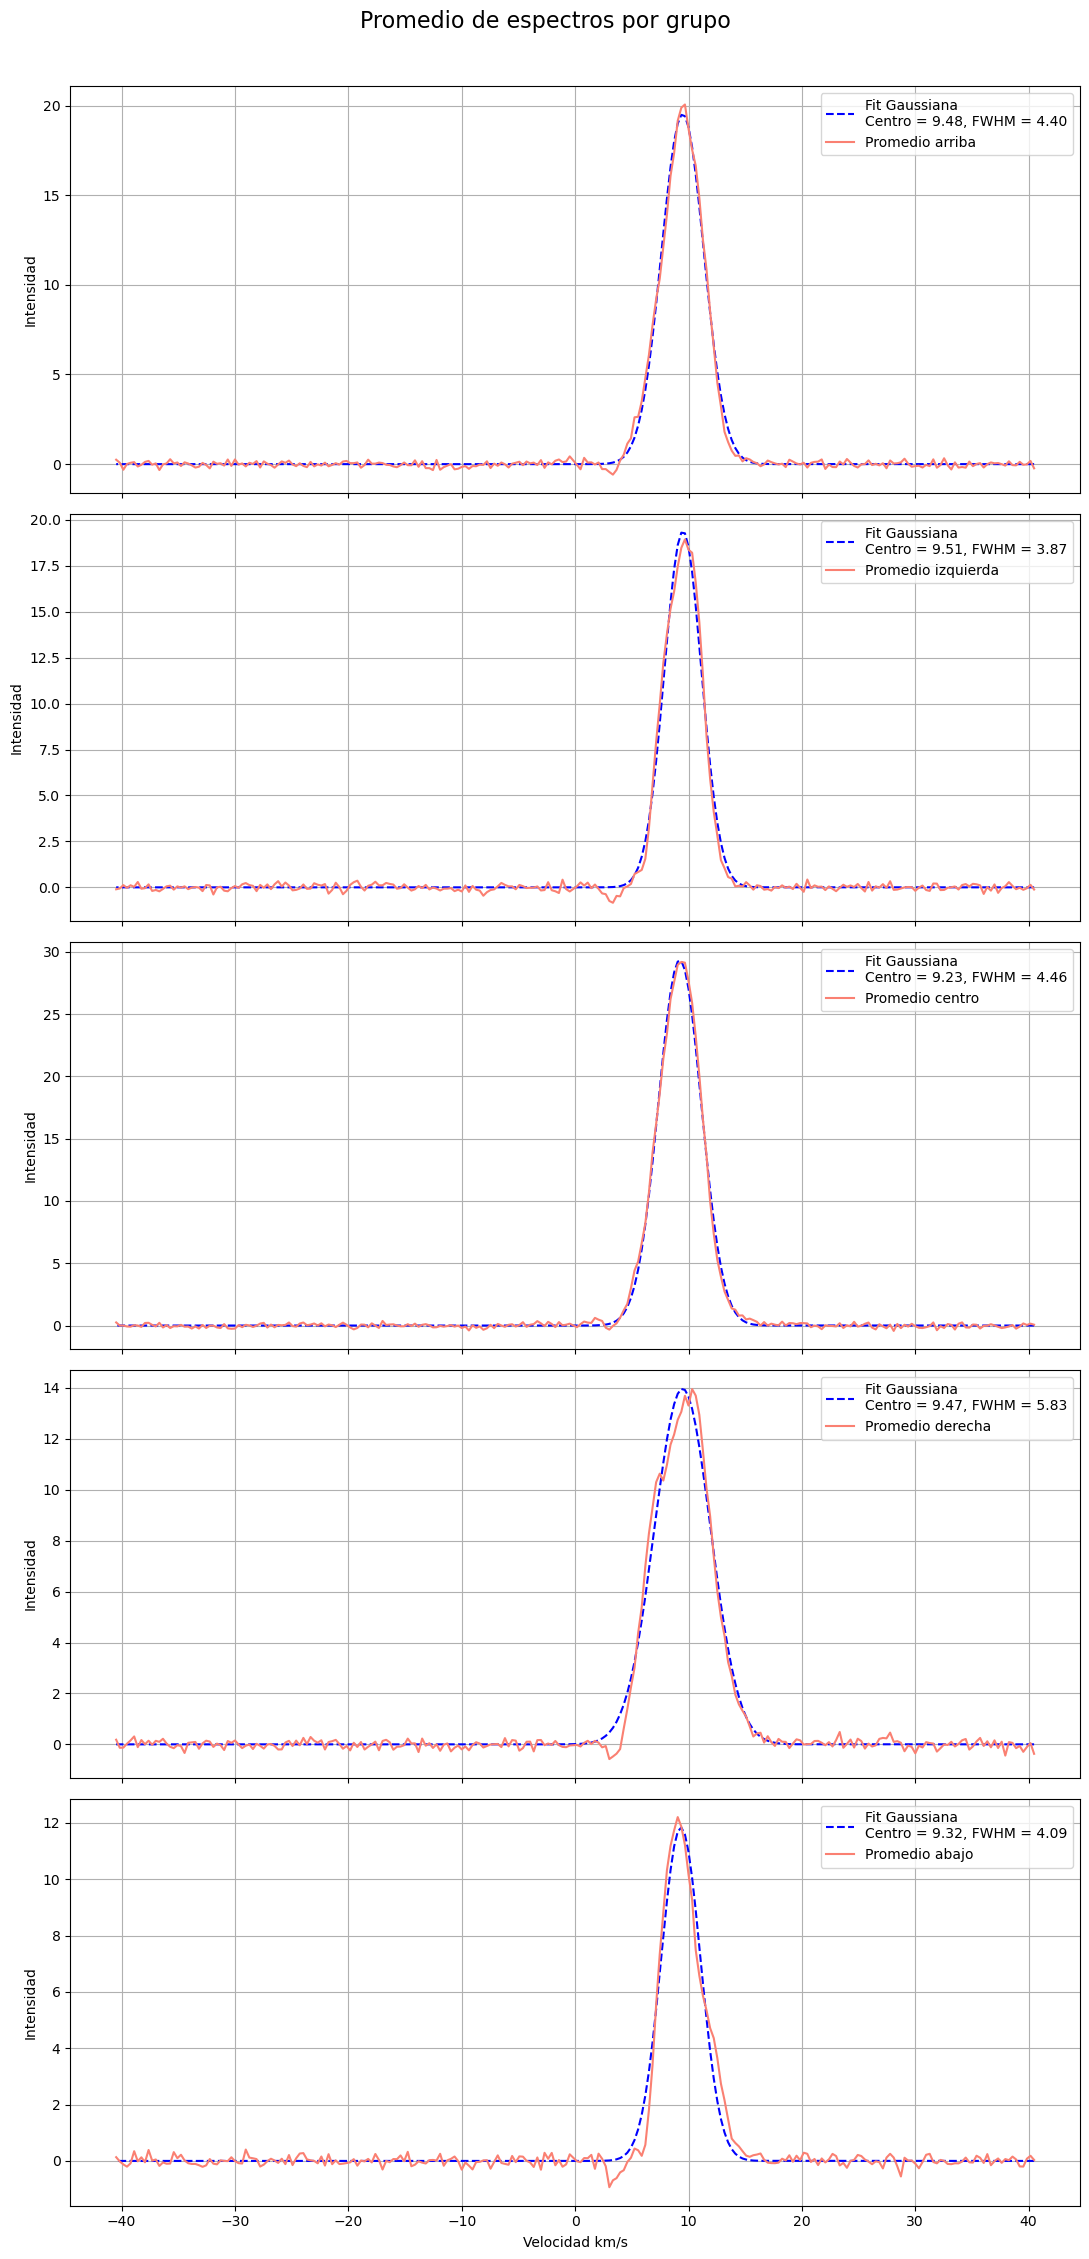


Array con todos los T_max. [19.52044622 19.38182867 29.35971518 13.97527805 11.83760103]


In [25]:
# Se plotea espectros promediados obtenidos para cada uno de los 5 puntos de la cruz
# Se define orden de los gráficos

tmax_list = [] # lista para guardar t_max en orden
orden = ["arriba", "izquierda", "centro", "derecha", "abajo"]

fig, axs = plt.subplots(5, 1, figsize = (11, 23), sharex = True)

for i, nombre_esp in enumerate(orden):
    datos = resultados[nombre_esp]
    promedio = datos["promedio"]

    c1 = promedio[:, 0] # columna 1
    c2 = promedio[:, 1] # columna 2

    # Se integra Gaussiana:
    popt, perr = fit_gaussiana(c1, c2)
    if popt is not None:
        y_fit = gaussian(c1, *popt)
        axs[i].plot(c1, y_fit, "r--", label = f"Fit Gaussiana\nCentro = {popt[0]:.2f}, FWHM = {popt[1]:.2f}", color = "b")

    # Se guardan valores de T_max !:
    t_max = popt[2]
    print(f"T_max {nombre_esp}: {t_max:.3f}") # print t_max
    tmax_list.append(t_max) # se guarda en lista
    # para gráficos
    axs[i].plot(c1, c2, label = f"Promedio {nombre_esp}", color = "salmon")
    axs[i].set_ylabel("Intensidad")
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel("Velocidad km/s")
fig.suptitle("Promedio de espectros por grupo", fontsize = 16)
plt.tight_layout(rect = [0, 0, 1, 0.97])
plt.show()

# Se convierte lista de t_max a numpy array.
tmax_array = np.array(tmax_list)
print("\nArray con todos los T_max.", tmax_array)


Demostración decaimiento error del promedio como $\frac{1}{\sqrt{N}}$:


Fiteo se encuentra ajustado a $T_{max}$ de cada espectro.

/var/folders/57/fg9ypknj7m5c97fm4cqm3bm40000gn/T/ipykernel_1371/2610662386.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(nn, yy,"o-r", label = r"$1/\sqrt{N}$", color = "orange")


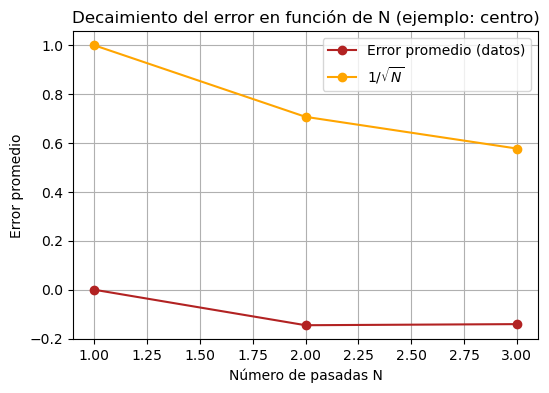

In [26]:
# función auxiliar: calcula error del promedio para N archivos
def calcular_error(archivos, df_total, N):
    subset = archivos[:N]
    df_esp = df_total[df_total["archivo"].isin(subset)].reset_index(drop=True)

    # 3 primeras columnas como valores numéricos
    espectros = df_esp.iloc[:, :3].apply(pd.to_numeric, errors="coerce").values
    espectros = espectros.reshape(N, -1, 3)

    # promedio y std
    promedio = espectros.mean(axis=0)
    if N > 1:
        std = espectros.std(axis=0, ddof=1)
        error = std / np.sqrt(N)
    else:
        std = espectros.std(axis=0, ddof=0)
        error = std / np.sqrt(N)
    return error

# Se elige un grupo de ejemplo: centro
archivos_centro = esp["centro"]  # ['sdf_113_113', 'sdf_118_118', 'sdf_123_123']

# Se calcula error para N=1,2,3
errores = []
for N in [1, 2, 3]:
    err = calcular_error(archivos_centro, df_total, N)
    # valor medio del error en todas las filas (para simplificar)
    errores.append(err[:,1].mean())  # columna 2 = intensidad
    
# función artesanal para comparar   
nn = np.array([1, 2, 3])
def decae(nn):
    return 1 / (nn) ** (1/2) 

# se evalúa
yy = decae(nn)

# gráfico: error real vs teoría
N_vals = np.array([1, 2, 3])
errores = -np.array(errores)

plt.figure(figsize=(6,4))
plt.plot(N_vals, errores, "o-", label="Error promedio (datos)", color = "firebrick")
plt.plot(nn, yy,"o-r", label = r"$1/\sqrt{N}$", color = "orange")
plt.xlabel("Número de pasadas N")
plt.ylabel("Error promedio")
plt.title("Decaimiento del error en función de N (ejemplo: centro)")
plt.legend()
plt.grid(True)
plt.show()


Trabajo con coordenadas:

/var/folders/57/fg9ypknj7m5c97fm4cqm3bm40000gn/T/ipykernel_1371/910346652.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_x, _ = curve_fit(gaussian, coord_x, vals_x, p0 = [0, 1, max(vals_x)])
/var/folders/57/fg9ypknj7m5c97fm4cqm3bm40000gn/T/ipykernel_1371/910346652.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_y, _ = curve_fit(gaussian, coord_y, vals_y, p0 = [0, 1, max(vals_y)])


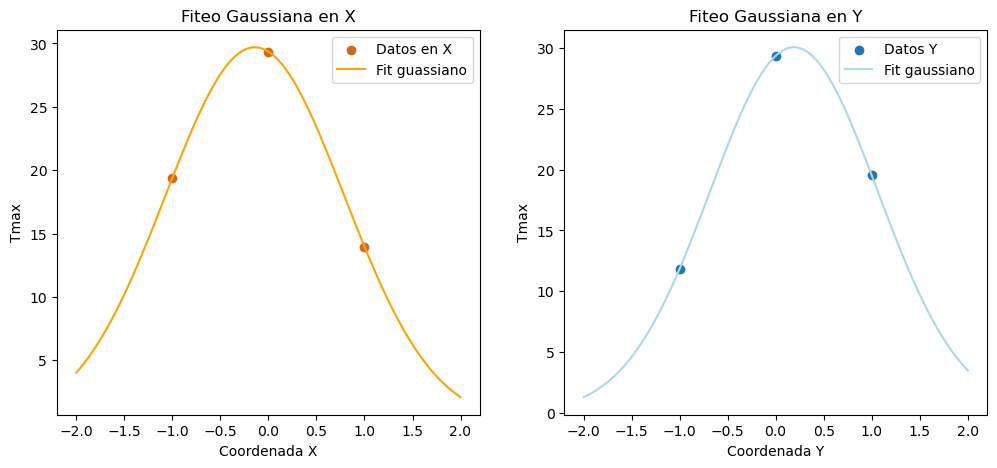

Resultados fiteo X (center, fwhm, peak): [-0.1412665   2.18877931 29.70110889]
Resultados fiteo Y (center, fwhm, peak): [ 0.18994314  2.05247785 30.06561097]


In [27]:
# Con Gaussiana anterior
Tmax = {"arriba": 19.520,
        "izquierda": 19.382,
        "centro": 29.360,
        "derecha": 13.975, 
        "abajo": 11.838
       }
# Coordenadas
# en x
coord_x = np.array ([-1, 0, 1])
vals_x = np.array([Tmax["izquierda"], Tmax["centro"], Tmax["derecha"]])

# en y
coord_y = np.array([-1, 0, 1])
vals_y = np.array([Tmax["abajo"], Tmax["centro"], Tmax["arriba"]])

# Ajuste Gaussiano
# en x
popt_x, _ = curve_fit(gaussian, coord_x, vals_x, p0 = [0, 1, max(vals_x)])

# en y
popt_y, _ = curve_fit(gaussian, coord_y, vals_y, p0 = [0, 1, max(vals_y)])

# Se grafican los resultados:

xx = np.linspace(-2, 2, 100)
yy = np.linspace(-2, 2, 100)

plt.figure(figsize = (12,5))

plt.subplot(1, 2, 1)
plt.scatter(coord_x, vals_x, label = "Datos en X", color = "chocolate")
plt.plot(xx, gaussian(xx, *popt_x), label = "Fit guassiano", color = "orange")
plt.title("Fiteo Gaussiana en X")
plt.xlabel("Coordenada X")
plt.ylabel("Tmax")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(coord_y, vals_y, label = "Datos Y")
plt.plot(yy, gaussian(yy, *popt_y), label = "Fit gaussiano", color = "lightblue")
plt.title("Fiteo Gaussiana en Y")
plt.xlabel("Coordenada Y")
plt.ylabel("Tmax")
plt.legend()

plt.show()

print("Resultados fiteo X (center, fwhm, peak):", popt_x)
print("Resultados fiteo Y (center, fwhm, peak):", popt_y)

        

Warning no preocupante (creo), considerando que son 3 muestras.

$T_{int}$

/var/folders/57/fg9ypknj7m5c97fm4cqm3bm40000gn/T/ipykernel_1328/3197624690.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Tint[nombre] = np.trapz(T, v) # integración numérica
/var/folders/57/fg9ypknj7m5c97fm4cqm3bm40000gn/T/ipykernel_1328/3197624690.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_x, pcov_x = curve_fit(gaussian_invertida_offset, coord_x, vals_x,
/var/folders/57/fg9ypknj7m5c97fm4cqm3bm40000gn/T/ipykernel_1328/3197624690.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_y, pcov_y = curve_fit(gaussian_invertida_offset, coord_y, vals_y,


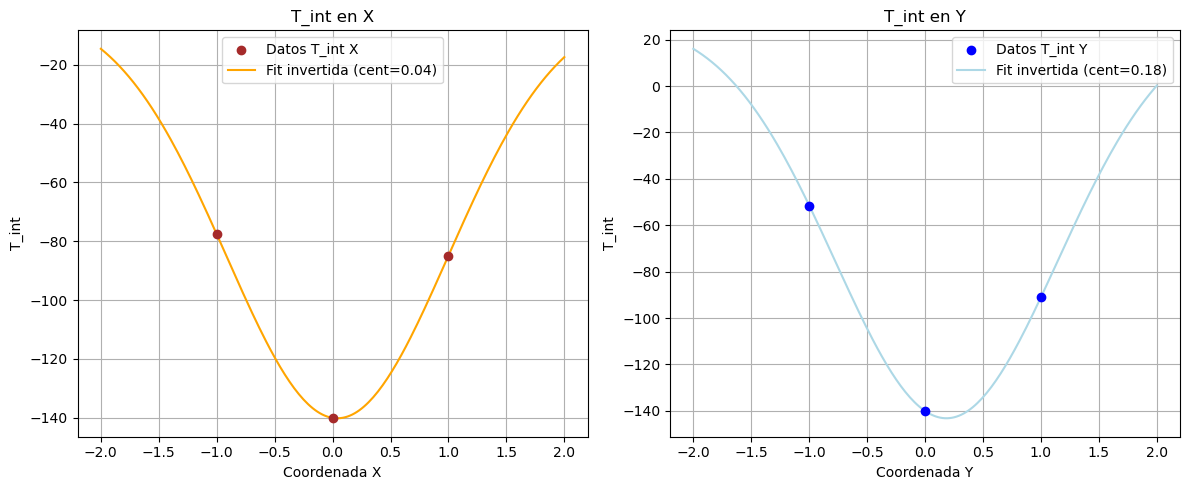

Parámetros X (center, fwhm, peak, offset): [ 4.11340656e-02  2.25191968e+00  1.39996612e+02 -2.09212561e-01]
Parámetros Y (center, fwhm, peak, offset): [  0.18410236   2.2611643  172.21739441  29.00416088]


In [24]:
# gaussiana con offset e invertida
def gaussian_invertida_offset(x, center, fwhm, peak, offset):
    sigma = fwhm / 2.355
    return offset - peak * np.exp(- (x - center)**2 / (2 * sigma**2))

# Se calcula T_int (promedios ya calculados)
orden = ["arriba", "izquierda", "centro", "derecha", "abajo"]
Tint = {}

for nombre in orden:
    promedio = resultados[nombre]["promedio"]    
    v = promedio[:,0]    # velocidad (o canal)
    T = promedio[:,1]    # intensidad
    Tint[nombre] = np.trapz(T, v) # integración numérica

# coordenadas y valores
coord_x = np.array([-1, 0, 1])  # izquierda, centro, derecha
vals_x = np.array([Tint["izquierda"], Tint["centro"], Tint["derecha"]])

coord_y = np.array([-1, 0, 1])  # abajo, centro, arriba
vals_y = np.array([Tint["abajo"], Tint["centro"], Tint["arriba"]])

# forzamiento peak>0 y fwhm>0
p0_x = [0.0, 1.0, np.ptp(vals_x), np.mean(vals_x)]
bounds_x = ([-np.inf, 1e-3, 1e-6, -np.inf], [np.inf, np.inf, np.inf, np.inf])

p0_y = [0.0, 1.0, np.ptp(vals_y), np.mean(vals_y)]
bounds_y = ([-np.inf, 1e-3, 1e-6, -np.inf], [np.inf, np.inf, np.inf, np.inf])

# curve_fit permite 4 parámetros con 3 puntos
# con 3 puntos la covarianza puede no estimarse.
try:
    popt_x, pcov_x = curve_fit(gaussian_invertida_offset, coord_x, vals_x,
                               p0=p0_x, bounds=bounds_x, maxfev=10000)
except Exception as e:
    print("Ajuste X falló:", e)
    popt_x, pcov_x = None, None

try:
    popt_y, pcov_y = curve_fit(gaussian_invertida_offset, coord_y, vals_y,
                               p0=p0_y, bounds=bounds_y, maxfev=10000)
except Exception as e:
    print("Ajuste Y falló:", e)
    popt_y, pcov_y = None, None

# Se grafican resultados
xx = np.linspace(-2, 2, 200)
yy = np.linspace(-2, 2, 200)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(coord_x, vals_x, color="brown", zorder=5, label="Datos T_int X")
if popt_x is not None:
    plt.plot(xx, gaussian_invertida_offset(xx, *popt_x), color="orange", label=f"Fit invertida (cent={popt_x[0]:.2f})")
plt.xlabel("Coordenada X")
plt.ylabel("T_int")
plt.title("T_int en X")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(coord_y, vals_y, color="blue", zorder=5, label="Datos T_int Y")
if popt_y is not None:
    plt.plot(yy, gaussian_invertida_offset(yy, *popt_y), color="lightblue", label=f"Fit invertida (cent={popt_y[0]:.2f})")
plt.xlabel("Coordenada Y")
plt.ylabel("T_int")
plt.title("T_int en Y")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Parámetros X (center, fwhm, peak, offset):", popt_x)
print("Parámetros Y (center, fwhm, peak, offset):", popt_y)
